In [2]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import time
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data

root = "../../../LocalGraphClustering"

import sys
sys.path.append(root)
sys.path.append(f"{root}/notebooks")

from localgraphclustering import *
from random import sample

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import networkx as nx

import warnings
warnings.filterwarnings('ignore')

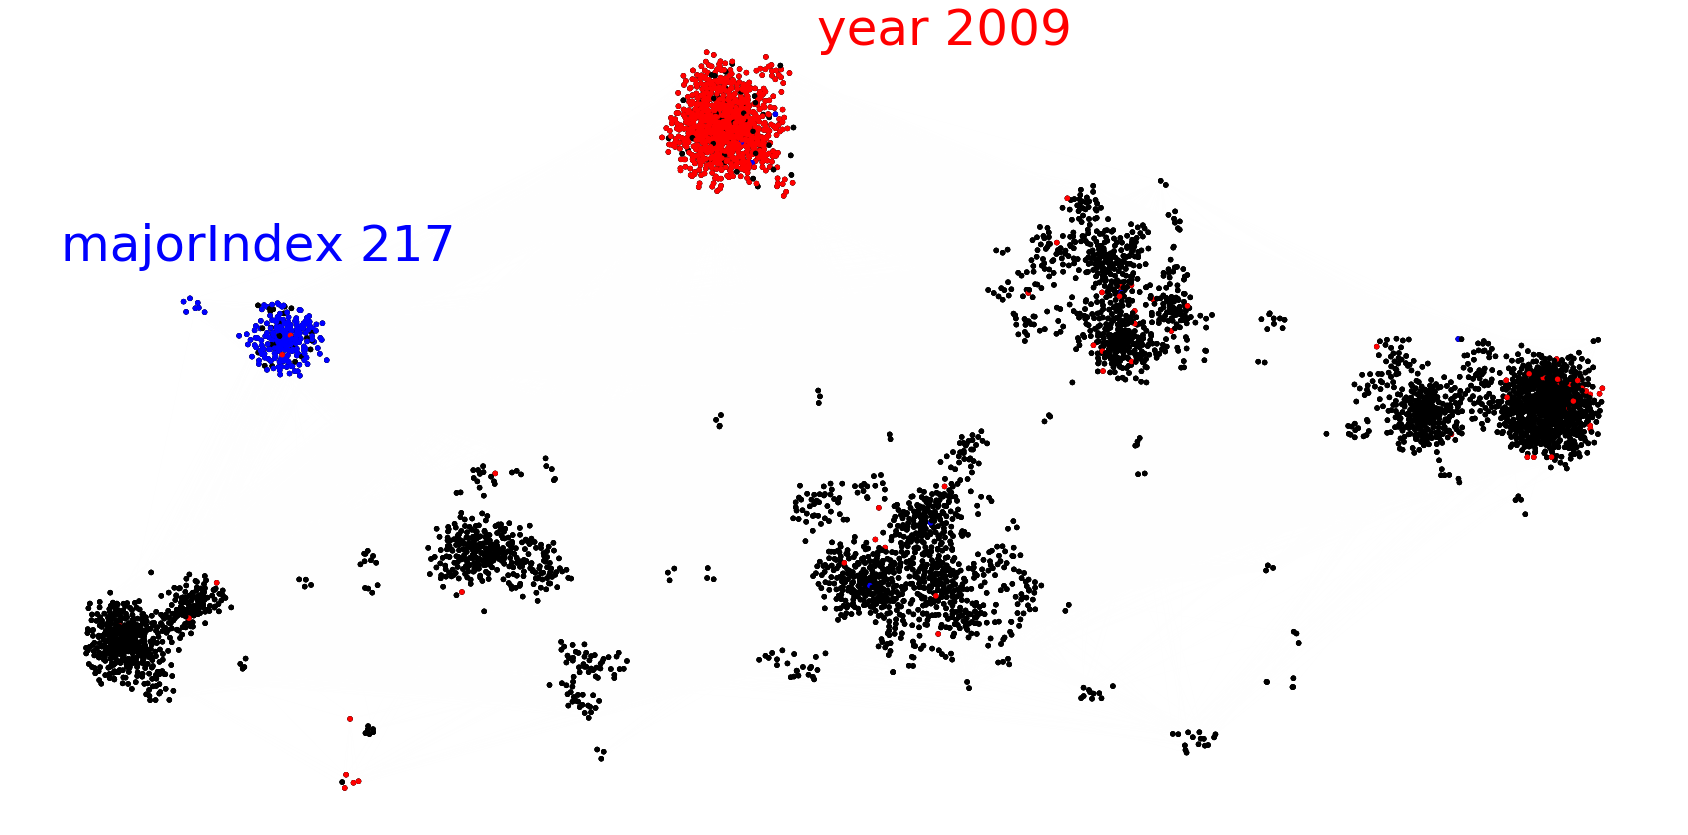

In [6]:
g = GraphLocal(f'{root}/notebooks/datasets/JohnsHopkins.graphml','graphml')

g_nx = nx.read_graphml(f'{root}/notebooks/datasets/JohnsHopkins.graphml')

target_cluster = []
counter = 0
for node in g_nx.nodes():
    if g_nx.node[node]['year'] == 2009.0:
        target_cluster.append(counter)
    counter += 1
    
target_cluster2 = []
counter = 0
for node in g_nx.nodes():
    if g_nx.node[node]['majorIndex'] == 217.0:
        target_cluster2.append(counter)
    counter += 1
    
ld_coord = np.loadtxt(f'{root}/notebooks/datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])
pos = np.zeros((g._num_vertices,2))
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]
    
node_colors = ['black' for i in range(g._num_vertices)]

drawing = g.draw(pos,figsize=(30,15),edgealpha=0.003,nodecolor='k',nodesize=30,nodelinewidth=0)

node_colors = np.array(['black' for i in range(g._num_vertices)])
node_colors[target_cluster] = 'red'
node_colors[target_cluster2] = 'blue'
drawing.ax.scatter(pos[:,0],pos[:,1],c=node_colors,s=30,linewidth=0,zorder=2)

# drawing.fig.savefig('jh_inputclusters_class_2009.png', format='png',bbox_inches='tight')

# temp = np.ones(g._num_vertices)
# temp[target_cluster] = 4
# temp[target_cluster2] = 4

# nodesize_list = 30*np.ones(g._num_vertices)
    
# nodeorder_list = [1 for i in range(g._num_vertices)]
# for i in target_cluster:
#     nodeorder_list[i] = 2
# for i in target_cluster2:
#     nodeorder_list[i] = 3

# drawing = g.draw_groups(pos,temp,figsize=(30,15),edgealpha=0.003,node_color_list=node_colors,nodesize_list=nodesize_list,nodeorder_list=nodeorder_list)

drawing.fig.text(0.15, 0.65, 'majorIndex 217', fontsize=50, color='blue')
drawing.fig.text(0.5, 0.85, 'year 2009', fontsize=50, color='red')
drawing.fig.savefig('jh_target_clusters.png', format='png',bbox_inches='tight')

# drawing.fig.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_targetclusters.png', format='png',bbox_inches='tight')

In [7]:
g = GraphLocal(f'{root}/notebooks/datasets/JohnsHopkins.graphml','graphml')

g_nx = nx.read_graphml(f'{root}/notebooks/datasets/JohnsHopkins.graphml')
ld_coord = np.loadtxt(f'{root}/notebooks/datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])
pos = np.zeros((g._num_vertices,2))
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]

target_cluster = []
counter = 0
for node in g_nx.nodes():
    if g_nx.node[node]['year'] == 2009.0:
        target_cluster.append(counter)
    counter += 1

In [8]:
def bfs(seeds,nsteps,g):
    visited = set(seeds)
    level = seeds
    for step in range(nsteps):
        new_level = []
        for node in level:
            for k in range(g.ai[node],g.ai[node+1]):
                neigh = g.aj[k]
                if neigh not in visited:
                    visited.add(neigh)
                    new_level.append(neigh)
        level = new_level
    return list(visited)

In [24]:
input_stats = []
output_stats = []
inputs = np.zeros(g._num_vertices)
outputs_mqi = np.zeros(g._num_vertices)
outputs_lfi = np.zeros(g._num_vertices)
ntrials = 25
for i in range(ntrials):
    np.random.seed(i)
    input_cluster = bfs(np.random.choice(target_cluster,1),2,g)
    input_cond = g.set_scores(input_cluster)['cond']
    output_cluster_mqi,cond_mqi = flow_clustering(g,input_cluster,method="mqi")
    output_cluster_lfi,cond_lfi = flow_clustering(g,input_cluster,method="sl")
    input_pr = len(set(target_cluster).intersection(input_cluster))/len(input_cluster)
    input_rc = len(set(target_cluster).intersection(input_cluster))/len(target_cluster)
    output_pr_mqi = len(set(target_cluster).intersection(output_cluster_mqi))/len(output_cluster_mqi)
    output_rc_mqi = len(set(target_cluster).intersection(output_cluster_mqi))/len(target_cluster)
    output_pr_lfi = len(set(target_cluster).intersection(output_cluster_lfi))/len(output_cluster_lfi)
    output_rc_lfi = len(set(target_cluster).intersection(output_cluster_lfi))/len(target_cluster)
    input_stats.append((input_pr,input_rc,input_cond,len(input_cluster)))
    output_stats.append((output_pr_mqi,output_rc_mqi,cond_mqi,len(output_cluster_mqi),output_pr_lfi,output_rc_lfi,cond_lfi,len(output_cluster_lfi)))
    inputs[input_cluster] += 1
    outputs_mqi[output_cluster_mqi] += 1
    outputs_lfi[output_cluster_lfi] += 1
    print(input_pr,input_rc,output_pr_mqi,output_rc_mqi,output_pr_lfi,output_rc_lfi)

0.3558939650310209 0.6934065934065934 0.9684044233807267 0.6736263736263737 0.9488703923900119 0.8769230769230769
0.5158562367864693 0.2681318681318681 0.9875518672199171 0.26153846153846155 0.9552023121387283 0.7263736263736263
0.5319961795606495 0.6120879120879121 0.9711711711711711 0.5923076923076923 0.9424206815511164 0.8813186813186813
0.4469055374592834 0.7538461538461538 0.9557142857142857 0.7351648351648352 0.7814814814814814 0.9274725274725275
0.1836734693877551 0.00989010989010989 0.6666666666666666 0.006593406593406593 0.7 0.007692307692307693
0.43870402802101577 0.5505494505494506 0.9779559118236473 0.5362637362637362 0.9466501240694789 0.8384615384615385
0.32019704433497537 0.6428571428571429 0.9619377162629758 0.610989010989011 0.9516728624535316 0.843956043956044
0.33919481721425265 0.8054945054945055 0.9580514208389715 0.778021978021978 0.9414519906323185 0.8835164835164835
0.37425149700598803 0.6868131868131868 0.9678972712680578 0.6626373626373626 0.9463007159904535 0

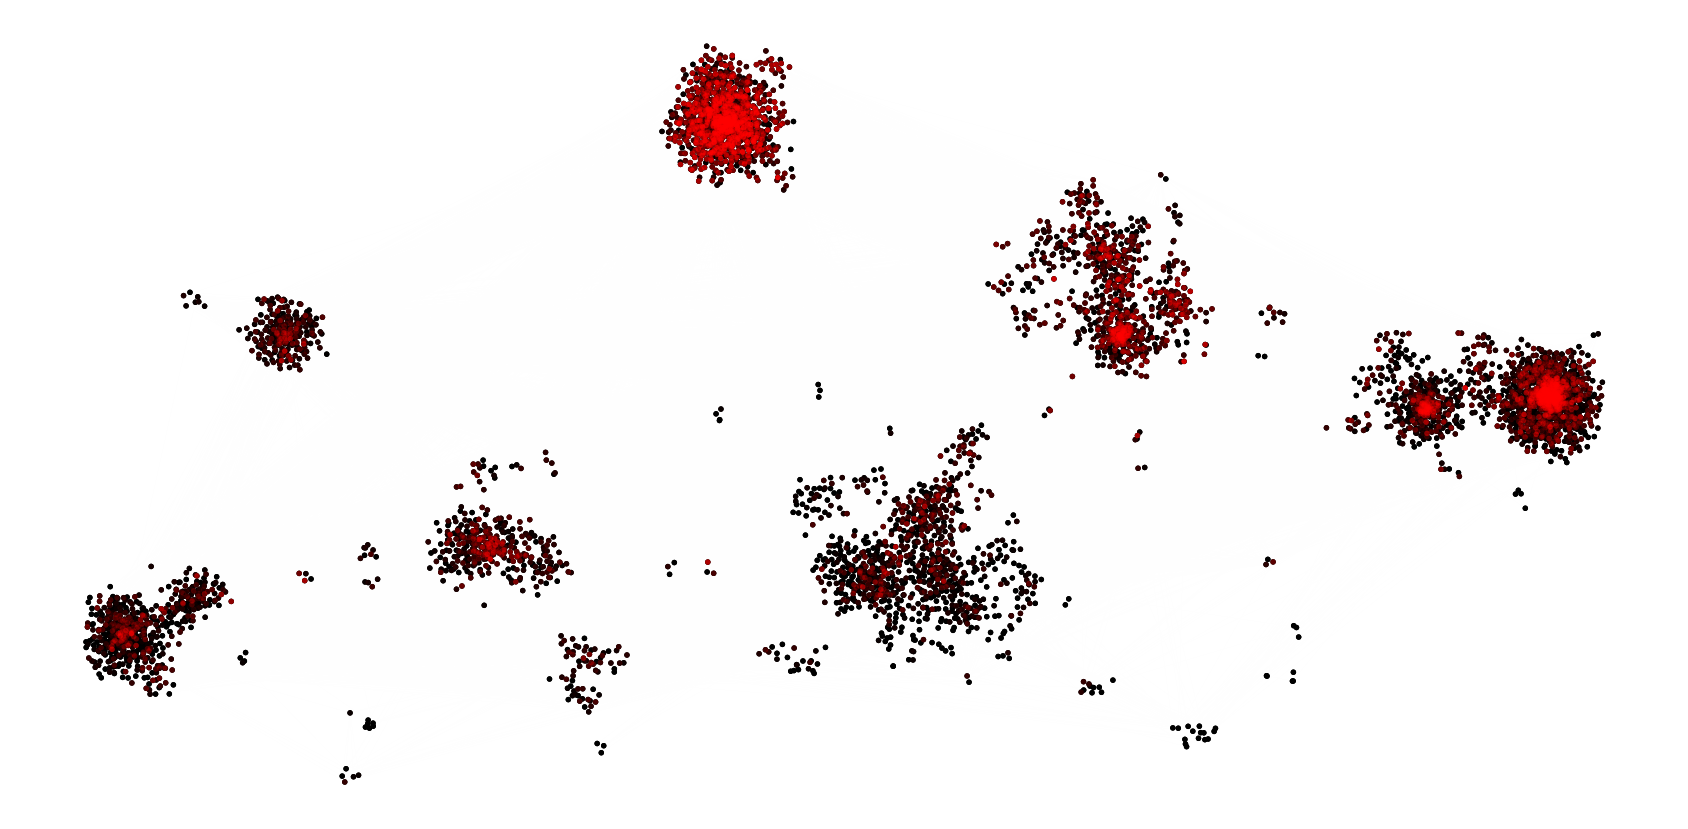

In [25]:
from matplotlib.colors import to_rgba

g = GraphLocal(f'{root}/notebooks/datasets/JohnsHopkins.graphml','graphml')

g_nx = nx.read_graphml(f'{root}/notebooks/datasets/JohnsHopkins.graphml')
    
ld_coord = np.loadtxt(f'{root}/notebooks/datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])
pddos = np.zeros((g._num_vertices,2))
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]
    
node_colors = np.array([to_rgba('r',alpha=inputs[i]/ntrials) for i in range(g._num_vertices)])

drawing = g.draw(pos,figsize=(30,15),edgealpha=0.003,nodecolor='k',nodesize=30,nodelinewidth=0)
drawing.ax.scatter(pos[:,0],pos[:,1],c=node_colors,s=30,linewidth=0,zorder=10)

drawing.fig.savefig('jh_inputclusters_class_2009.png', format='png',bbox_inches='tight')

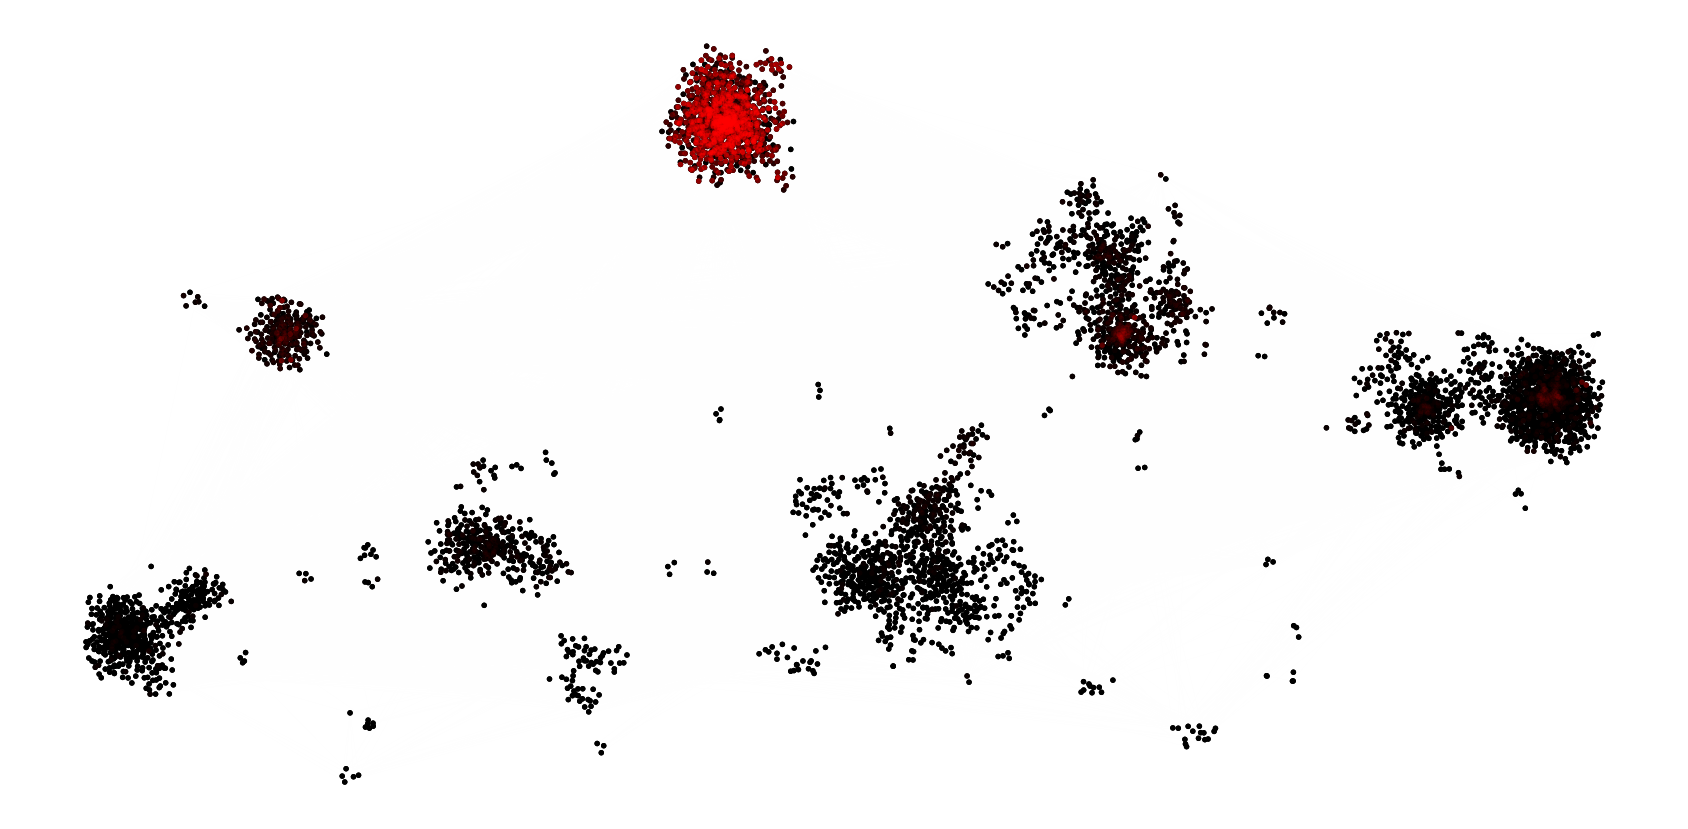

In [26]:
from matplotlib.colors import to_rgba

g = GraphLocal(f'{root}/notebooks/datasets/JohnsHopkins.graphml','graphml')

g_nx = nx.read_graphml(f'{root}/notebooks/datasets/JohnsHopkins.graphml')
    
ld_coord = np.loadtxt(f'{root}/notebooks/datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])
pddos = np.zeros((g._num_vertices,2))
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]
    
node_colors = np.array([to_rgba('r',alpha=outputs_mqi[i]/ntrials) for i in range(g._num_vertices)])

drawing = g.draw(pos,figsize=(30,15),edgealpha=0.003,nodecolor='k',nodesize=30,nodelinewidth=0)
drawing.ax.scatter(pos[:,0],pos[:,1],c=node_colors,s=30,linewidth=0,zorder=10)

drawing.fig.savefig('jh_mqiclusters_class_2009.png', format='png',bbox_inches='tight')

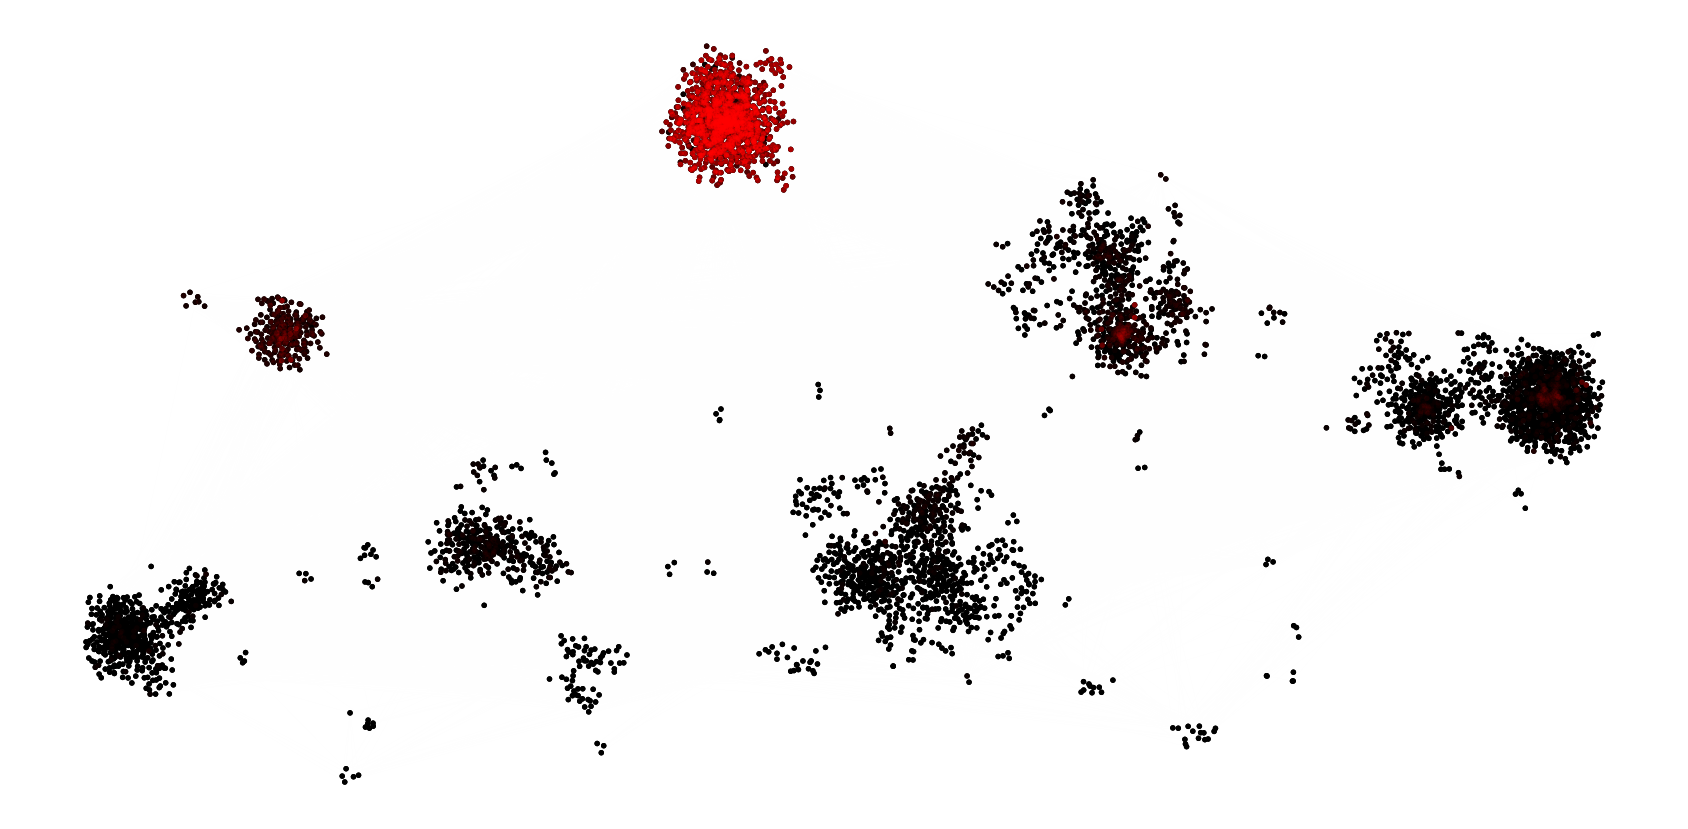

In [27]:
from matplotlib.colors import to_rgba

g = GraphLocal(f'{root}/notebooks/datasets/JohnsHopkins.graphml','graphml')

g_nx = nx.read_graphml(f'{root}/notebooks/datasets/JohnsHopkins.graphml')
    
ld_coord = np.loadtxt(f'{root}/notebooks/datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])
pddos = np.zeros((g._num_vertices,2))
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]
    
node_colors = np.array([to_rgba('r',alpha=outputs_lfi[i]/ntrials) for i in range(g._num_vertices)])

drawing = g.draw(pos,figsize=(30,15),edgealpha=0.003,nodecolor='k',nodesize=30,nodelinewidth=0)
drawing.ax.scatter(pos[:,0],pos[:,1],c=node_colors,s=30,linewidth=0,zorder=10)

drawing.fig.savefig('jh_lficlusters_class_2009.png', format='png',bbox_inches='tight')

In [28]:
g = GraphLocal(f'{root}/notebooks/datasets/JohnsHopkins.graphml','graphml')

g_nx = nx.read_graphml(f'{root}/notebooks/datasets/JohnsHopkins.graphml')
ld_coord = np.loadtxt(f'{root}/notebooks/datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])
pos = np.zeros((g._num_vertices,2))
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]

target_cluster2 = []
counter = 0
for node in g_nx.nodes():
    if g_nx.node[node]['majorIndex'] == 217.0:
        target_cluster2.append(counter)
    counter += 1

In [40]:
input_stats2 = []
output_stats2 = []
inputs2 = np.zeros(g._num_vertices)
outputs_mqi2 = np.zeros(g._num_vertices)
outputs_lfi2 = np.zeros(g._num_vertices)
for i in range(ntrials):
    np.random.seed(i)
    input_cluster = bfs(np.random.choice(target_cluster2,1),2,g)
    output_cluster_mqi,cond_mqi = flow_clustering(g,input_cluster,method="mqi")
    output_cluster_lfi,cond_lfi = flow_clustering(g,input_cluster,method="sl")
    input_pr = len(set(target_cluster2).intersection(input_cluster))/len(input_cluster)
    input_rc = len(set(target_cluster2).intersection(input_cluster))/len(target_cluster2)
    input_cond = g.set_scores(input_cluster)['cond']
    output_pr_mqi = len(set(target_cluster2).intersection(output_cluster_mqi))/len(output_cluster_mqi)
    output_rc_mqi = len(set(target_cluster2).intersection(output_cluster_mqi))/len(target_cluster2)
    output_pr_lfi = len(set(target_cluster2).intersection(output_cluster_lfi))/len(output_cluster_lfi)
    output_rc_lfi = len(set(target_cluster2).intersection(output_cluster_lfi))/len(target_cluster2)
    input_stats2.append((input_pr,input_rc,input_cond,len(input_cluster)))
    output_stats2.append((output_pr_mqi,output_rc_mqi,cond_mqi,len(output_cluster_mqi),output_pr_lfi,output_rc_lfi,cond_lfi,len(output_cluster_lfi)))
    inputs2[input_cluster] += 1
    outputs_mqi2[output_cluster_mqi] += 1
    outputs_lfi2[output_cluster_lfi] += 1
    print(input_pr,input_rc,output_pr_mqi,output_rc_mqi,output_pr_lfi,output_rc_lfi)

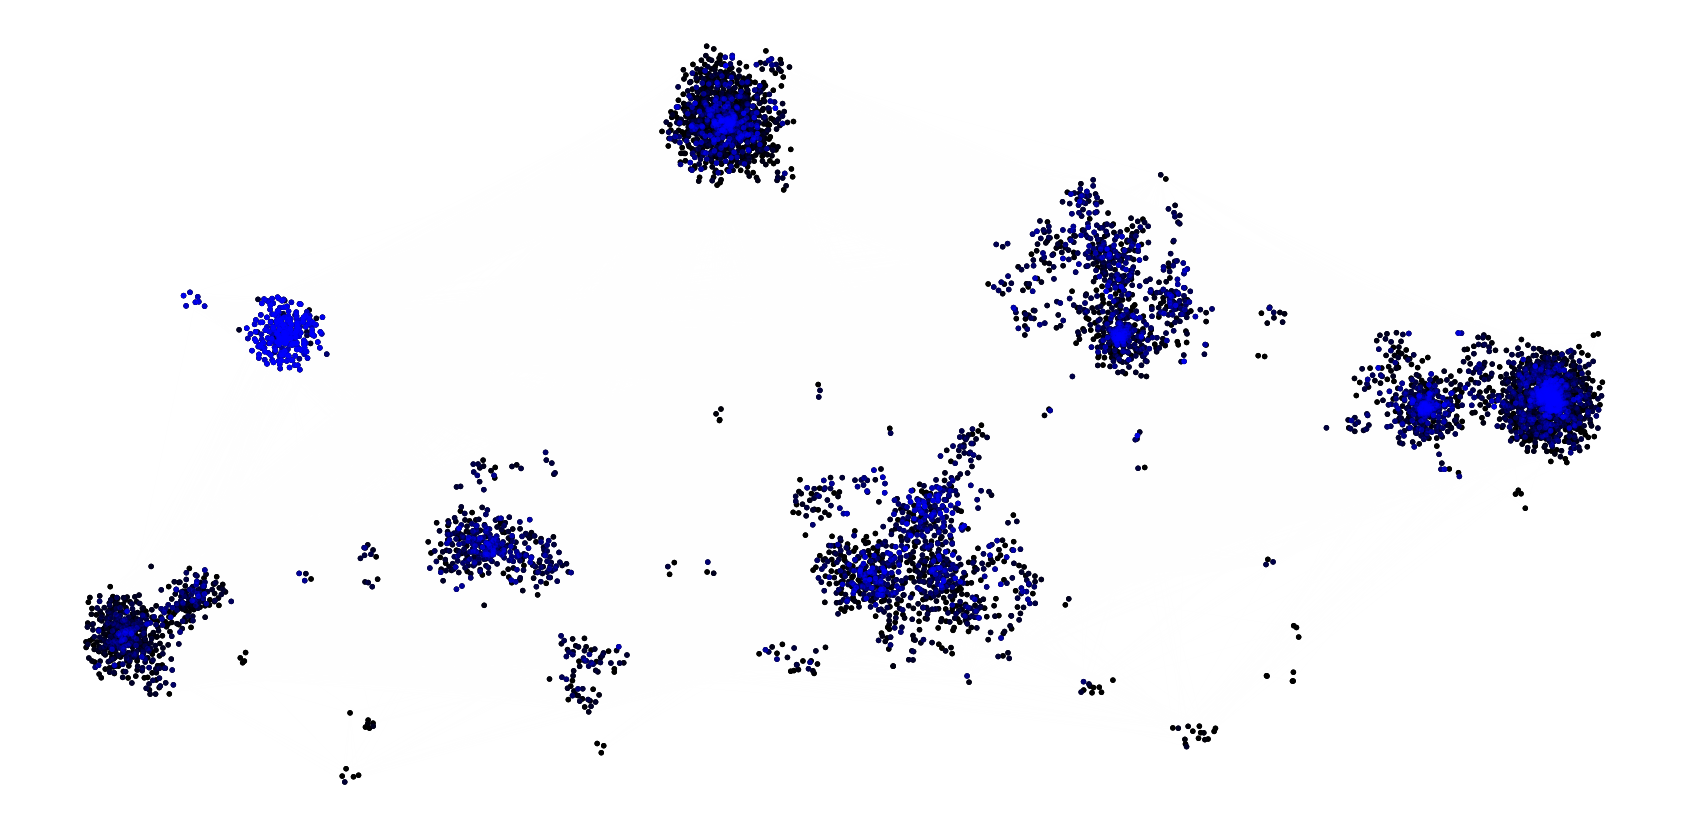

In [30]:
from matplotlib.colors import to_rgba

g = GraphLocal(f'{root}/notebooks/datasets/JohnsHopkins.graphml','graphml')

g_nx = nx.read_graphml(f'{root}/notebooks/datasets/JohnsHopkins.graphml')
    
ld_coord = np.loadtxt(f'{root}/notebooks/datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])
pddos = np.zeros((g._num_vertices,2))
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]
    
node_colors = np.array([to_rgba('b',alpha=inputs2[i]/ntrials) for i in range(g._num_vertices)])

drawing = g.draw(pos,figsize=(30,15),edgealpha=0.003,nodecolor='k',nodesize=30,nodelinewidth=0)
drawing.ax.scatter(pos[:,0],pos[:,1],c=node_colors,s=30,zorder=10,linewidth=0)

drawing.fig.savefig('jh_inputclusters_major_217.png', format='png',bbox_inches='tight')

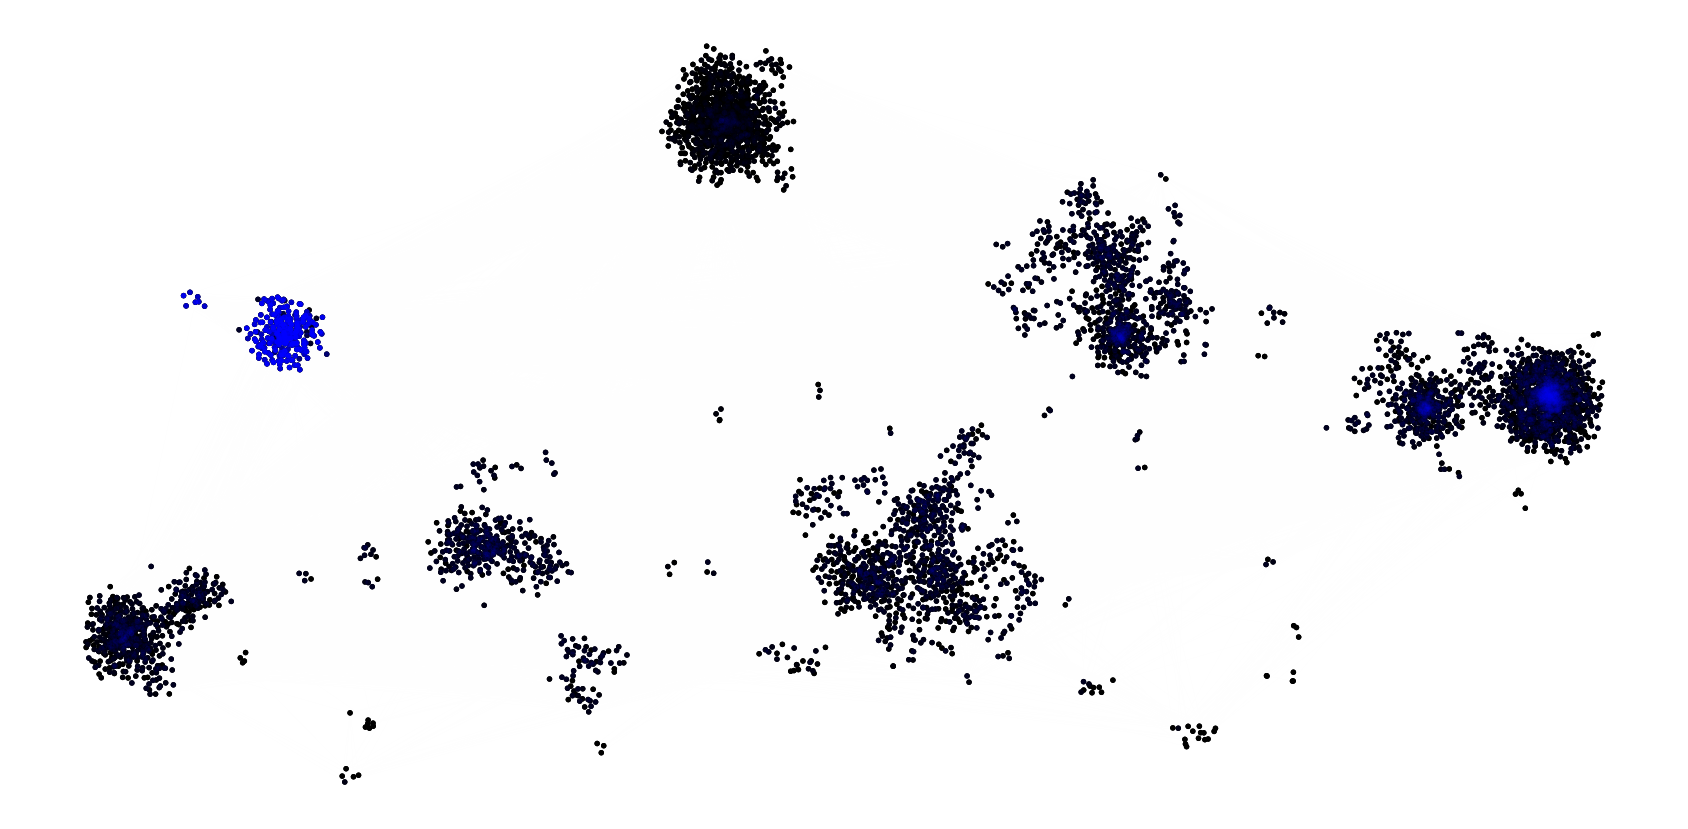

In [31]:
from matplotlib.colors import to_rgba

g = GraphLocal(f'{root}/notebooks/datasets/JohnsHopkins.graphml','graphml')

g_nx = nx.read_graphml(f'{root}/notebooks/datasets/JohnsHopkins.graphml')
    
ld_coord = np.loadtxt(f'{root}/notebooks/datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])
pddos = np.zeros((g._num_vertices,2))
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]
    
node_colors = np.array([to_rgba('b',alpha=outputs_mqi2[i]/ntrials) for i in range(g._num_vertices)])

drawing = g.draw(pos,figsize=(30,15),edgealpha=0.003,nodecolor='k',nodesize=30,nodelinewidth=0)
drawing.ax.scatter(pos[:,0],pos[:,1],c=node_colors,s=30,zorder=10,linewidth=0)

drawing.fig.savefig('jh_mqiclusters_major_217.png', format='png',bbox_inches='tight')

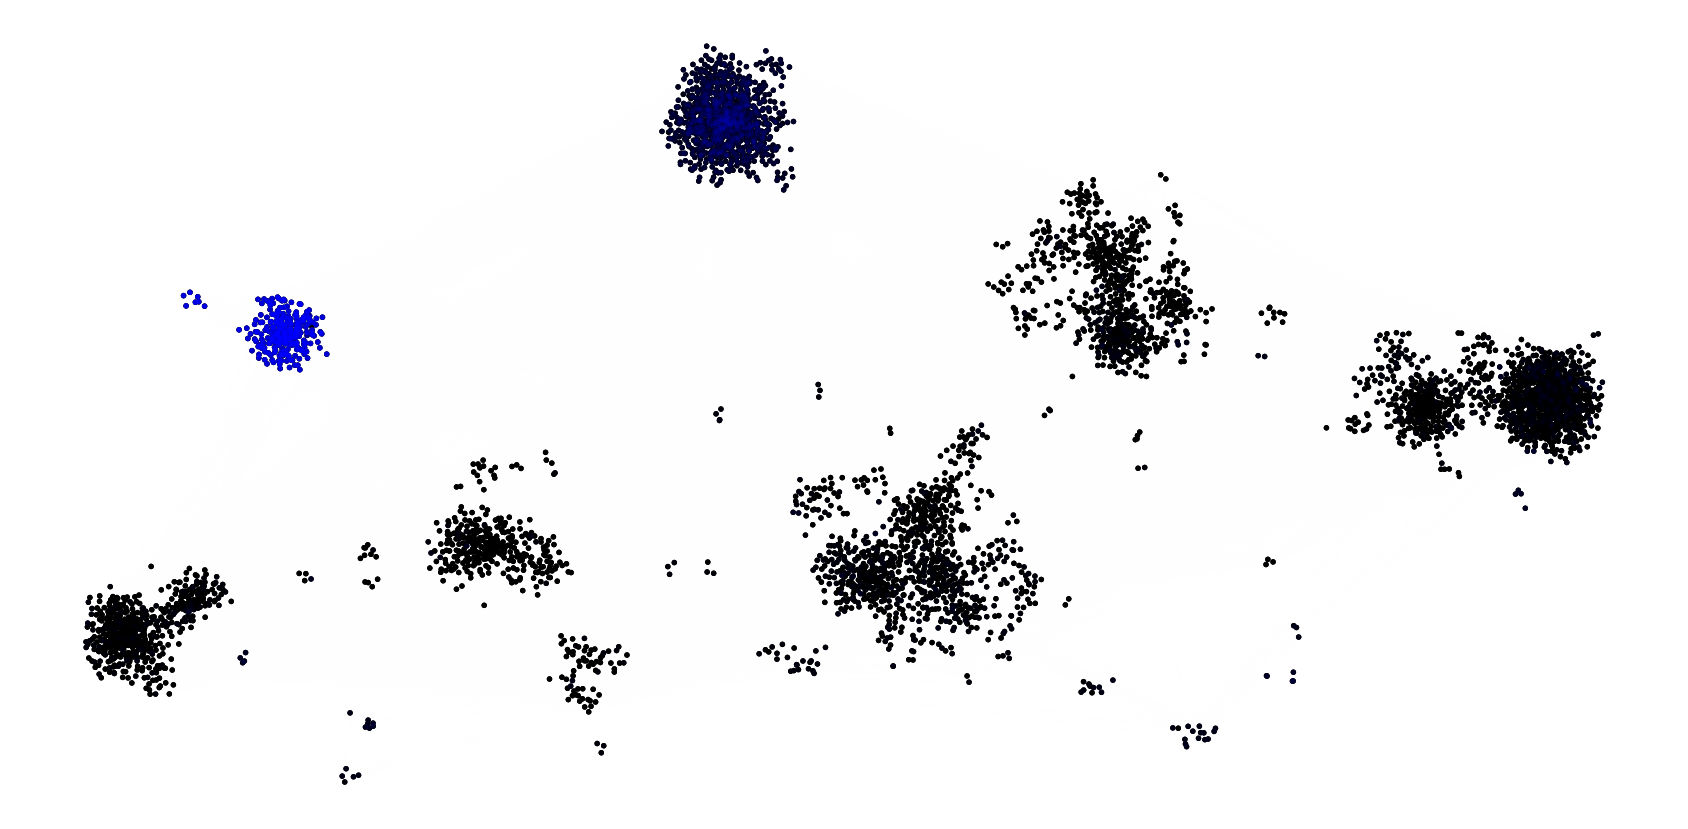

In [32]:
from matplotlib.colors import to_rgba

g = GraphLocal(f'{root}/notebooks/datasets/JohnsHopkins.graphml','graphml')

g_nx = nx.read_graphml(f'{root}/notebooks/datasets/JohnsHopkins.graphml')
    
ld_coord = np.loadtxt(f'{root}/notebooks/datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])
pddos = np.zeros((g._num_vertices,2))
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]
    
node_colors = np.array([to_rgba('b',alpha=outputs_lfi2[i]/ntrials) for i in range(g._num_vertices)])

drawing = g.draw(pos,figsize=(30,15),edgealpha=0.003,nodecolor='k',nodesize=30,nodelinewidth=0)
drawing.ax.scatter(pos[:,0],pos[:,1],c=node_colors,s=30,zorder=10,linewidth=0)

drawing.fig.savefig('jh_lficlusters_major_217.png', format='png',bbox_inches='tight')

In [33]:
print(
    np.median([i[0] for i in input_stats]),
    np.median([i[1] for i in input_stats]),
    np.median([i[2] for i in input_stats]),
    np.median([i[3] for i in input_stats])
)

0.3557422969187675 0.5131868131868131 0.5235471691470917 1129.0


In [34]:
print(
    np.median([i[0] for i in output_stats]),
    np.median([i[1] for i in output_stats]),
    np.median([i[2] for i in output_stats]),
    np.median([i[3] for i in output_stats])
)

0.9619377162629758 0.4967032967032967 0.28783406147911994 472.0


In [35]:
print(
    np.median([i[4] for i in output_stats]),
    np.median([i[5] for i in output_stats]),
    np.median([i[6] for i in output_stats]),
    np.median([i[7] for i in output_stats])
)

0.9414519906323185 0.8274725274725274 0.17720173885042667 802.0


In [41]:
print(
    np.median([i[0] for i in input_stats2]),
    np.median([i[1] for i in input_stats2]),
    np.median([i[2] for i in input_stats2]),
    np.median([i[3] for i in input_stats2])
)

0.1497695852534562 0.9353233830845771 0.5820174055923346 1282.0


In [37]:
print(
    np.median([i[0] for i in output_stats2]),
    np.median([i[1] for i in output_stats2]),
    np.median([i[2] for i in output_stats2]),
    np.median([i[3] for i in output_stats2])
)

0.8952380952380953 0.900497512437811 0.18739948916847982 203.0


In [38]:
print(
    np.median([i[4] for i in output_stats2]),
    np.median([i[5] for i in output_stats2]),
    np.median([i[6] for i in output_stats2]),
    np.median([i[7] for i in output_stats2])
)

0.8761467889908257 0.9502487562189055 0.18069973087274124 218.0
